In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['FB','AMZN','GOOG','TWTR','TSLA']**

In [2]:
import yfinance as yf
stock_symbol = 'GOOG'
data = yf.download(tickers=stock_symbol,period='2y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
500,2022-03-18,2677.679932,2738.270020,2658.639893,2736.030029,2736.030029,2291100
501,2022-03-21,2736.949951,2751.649902,2692.229980,2729.570068,2729.570068,1331600
502,2022-03-22,2730.000000,2830.000000,2730.000000,2805.550049,2805.550049,1488800
503,2022-03-23,2782.770020,2800.500000,2763.330078,2770.070068,2770.070068,1265100
504,2022-03-24,2785.449951,2827.929932,2760.788086,2826.239990,2826.239990,1026100


#### Visualizing the Real Stock Trend

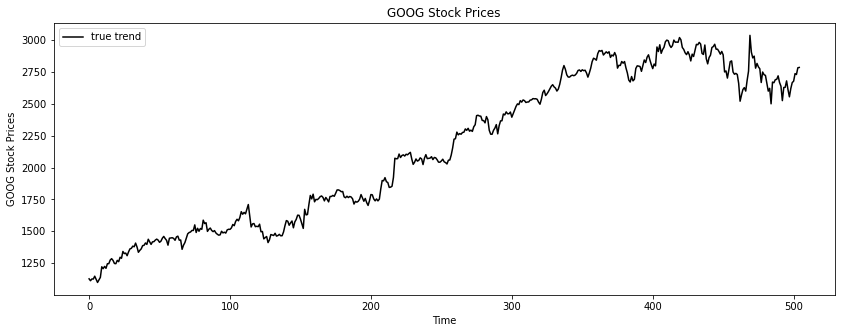

In [3]:
plt.figure(figsize=(14,5))
plt.plot(data['Open'],color='black',label='true trend')
plt.title('%s Stock Prices'%stock_symbol)
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [4]:
test_size = 30
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((505, 7), (475, 7), (30, 7))

#### Preparing the training data

In [5]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,1126.469971,1148.900024,1086.010010,1102.489990,4081500
1,1111.800049,1169.969971,1093.530029,1161.750000,3571700
2,1125.670044,1150.670044,1105.910034,1110.709961,3208500
3,1125.040039,1151.630005,1096.479980,1146.819946,2574100
4,1147.300049,1175.310059,1138.140015,1162.810059,2486400


In [6]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.01454864, 0.01321893, 0.00323261, 0.00240567, 0.90194895])

In [7]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,0])
# last 60 days will be the training set - X
# 61st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape
# 385 rows
# 60 columns
# 5 dimentional data

((445, 30, 5), (445,))

#### Preparaing testing data

In [8]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

((60, 5),
             Open         High          Low        Close   Volume
 445  2928.590088  2943.675049  2910.090088  2930.090088   851100
 446  2929.000000  2941.250000  2915.169922  2920.050049   648900
 447  2910.879883  2927.300049  2893.550049  2893.590088   864900
 448  2889.510010  2911.000000  2870.050049  2901.489990  1260700
 449  2911.010010  2932.199951  2876.322998  2888.330078  1146400)

In [9]:
df = scaler.transform(df)
df[0]

array([0.94395081, 0.94874798, 0.95429476, 0.95611864, 0.121791  ])

In [10]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,0])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((30, 30, 5), (30,))

#### Defining the Scaling Label

In [11]:
# below is the scaling label, 
# therefore we need to divide our y_pred with the below scaling value it used to scale the data
scaler.scale_

array([5.15727095e-04, 5.21251431e-04, 5.21392760e-04, 5.21838980e-04,
       2.41505060e-07])

In [12]:
scale = 1/8.50296711e-04
scale

1176.0600588751424

In [13]:
y_test = y_test*scale

### Bidirectional LSTM - (Long Short-Term Memory)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional

In [15]:
x_train.shape[1],x_train.shape[2]

(30, 5)

In [16]:
model = Sequential()

# 1st layer
model.add(Bidirectional(LSTM(40,return_sequences=True,dropout=0.2),input_shape=(x_train.shape[1],x_train.shape[2])))
#regression.add(Dropout(0.2))

# 2nd layer
#model.add(Bidirectional(LSTM(20,return_sequences=True)))
#regression.add(Dropout(0.2))

# 3rd layer
#model.add(LSTM(units=80,return_sequences=True))
#regression.add(Dropout(0.2))

# Final layer
model.add(Bidirectional(LSTM(20,dropout=0.2)))
#regression.add(Dropout(0.5))

model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 30, 80)           14720     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               16160     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 30,921
Trainable params: 30,921
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics='accuracy')

In [18]:
def forecast():
    model.fit(x_train,y_train,epochs=100,batch_size=32)
    y_pred = model.predict(x_test)
    y_pred = y_pred*scale
    return y_pred

In [19]:
def first_forecast():
    history = model.fit(x_train,y_train,epochs=100,batch_size=32)
    y_pred = model.predict(x_test)
    y_pred = y_pred*scale
    return history,y_pred

In [20]:
result_forecast = []
simulation = 1
print("Simulation 1")
history,first_result = first_forecast()
result_forecast.append(first_result)
for i in range(1,simulation):
    print("Simulation %d"%(i+1))
    result_forecast.append(forecast())


Simulation 1
Epoch 1/100
14/14 [==============================] - 5s 21ms/step - loss: 0.0321 - accuracy: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 0s 20ms/step - loss: 0.0080 - accuracy: 0.0022
Epoch 3/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0038 - accuracy: 0.0022
Epoch 4/100
14/14 [==============================] - 0s 18ms/step - loss: 0.0029 - accuracy: 0.0022
Epoch 5/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0029 - accuracy: 0.0022
Epoch 6/100
14/14 [==============================] - 0s 18ms/step - loss: 0.0023 - accuracy: 0.0022
Epoch 7/100
14/14 [==============================] - 0s 18ms/step - loss: 0.0026 - accuracy: 0.0022
Epoch 8/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0026 - accuracy: 0.0022
Epoch 9/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0025 - accuracy: 0.0022
Epoch 10/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0023 -

#### Calculating the Accuracy using RMSE

In [21]:
# MAPE - Mean Absolute Percentage Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    # mean Absolute Percentage Error - MAPE
    percentage = 1 - np.mean(np.abs((real-predict)/real))
    return percentage * 100
mean_accuracy = []
for i in range(simulation):
    mean_accuracy.append(calculate_accuracy(y_test, result_forecast[i]))

mean_accuracy

[94.66424744141939]

In [22]:
# RMSE - Root Mean Squared Error 
temp = 1 - np.sqrt(np.mean(np.square((y_test - result_forecast[0])/y_test)))
temp*100

93.15921219760406

#### Visualization

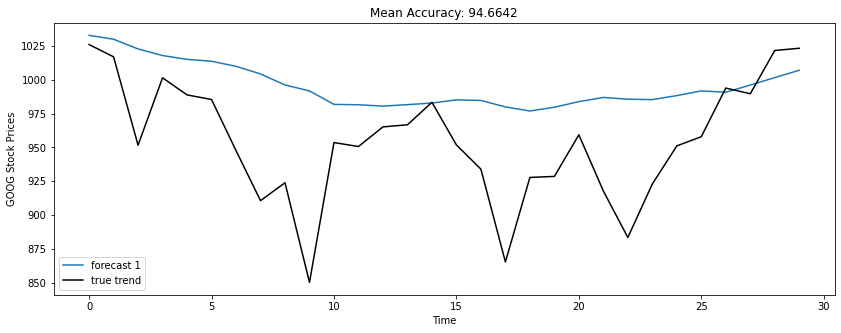

In [23]:
plt.figure(figsize=(14,5))
for i in range(simulation):
    plt.plot(result_forecast[i],label='forecast %d'%(i+1))
plt.plot(y_test,color='black',label='true trend')
plt.title('Mean Accuracy: %.4f'%np.mean(mean_accuracy))
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

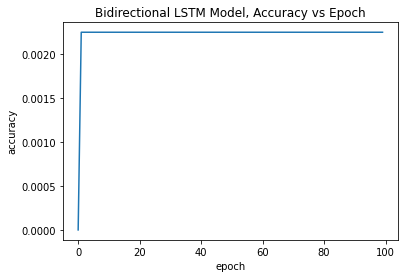

In [25]:
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Bidirectional LSTM Model, Accuracy vs Epoch')
plt.show()

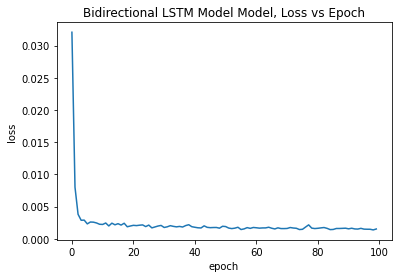

In [26]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Bidirectional LSTM Model Model, Loss vs Epoch')
plt.show()

### Analysis

**Trial 1**

**Dataset:**
>* GOOG
>* 2y 

**Training Timestamp:**
>* 30 days 

**Model:**
>* 2 layers
>* activation = relu
>* units = 40,20
>* dropout = 0.2,0.2
>* dense units = 1 

**Compile:**
>* optimizer = adam 

**Training:**
>* epochs = 100
>* batch_size = 32  

**Accuracy:**
>* MAPE - 94.66%
>* RMSE - 93.15%